### Import libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

###Read the data, check for inconsistencies and transform it according to the use.

In [6]:
salesDF = pd.read_csv('MonthlySales.csv')
salesDF.isnull().sum()


date     0
sales    0
dtype: int64

In [7]:
# convert date column to datatime object and create seperate columns for month and year
salesDF['date'] = pd.to_datetime(salesDF['date'], format='%m/%d/%Y')
salesDF['year'] = salesDF['date'].dt.year
salesDF['month'] = salesDF['date'].dt.month
salesDF.head()

,date,sales,year,month
0,2017-01-01,14236.90,2017,1
1,2017-02-01,4519.89,2017,2
2,2017-03-01,55691.01,2017,3
3,2017-04-01,28295.35,2017,4
4,2017-05-01,23648.29,2017,5


###Visualize the previous years' average sales data

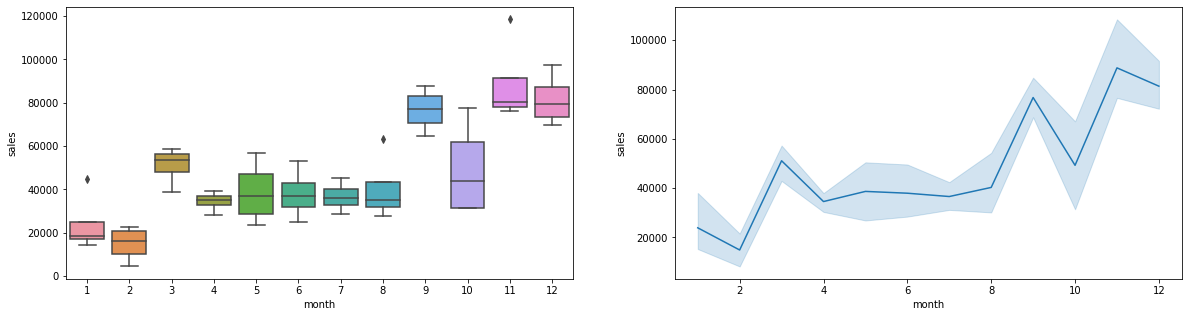

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
sn.boxplot(x='month', y='sales', data=salesDF, ax=axs[0])
sn.lineplot(x='month', y='sales', data=salesDF, ax=axs[1])

###Visualize the yearly sales

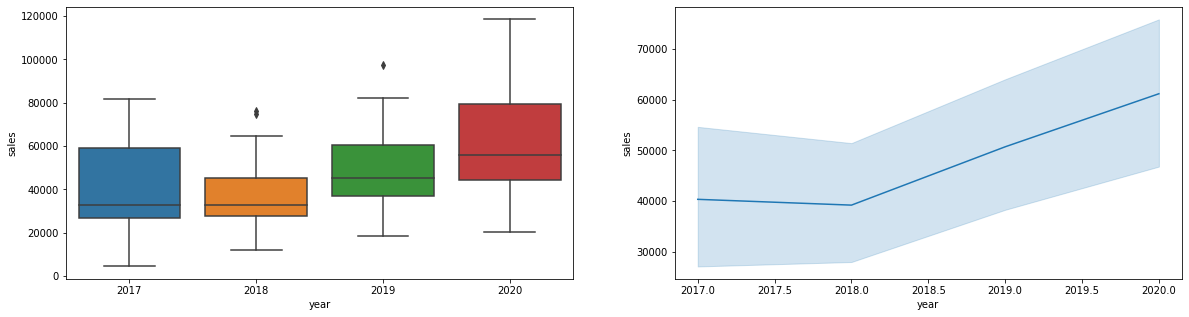

In [9]:
fig1, axs = plt.subplots(ncols=2, figsize=(20,5))
sn.boxplot(x='year', y='sales', data=salesDF, ax=axs[0])
sn.lineplot(x='year', y='sales', data=salesDF, ax=axs[1])

###Visualize the sales over all the years.

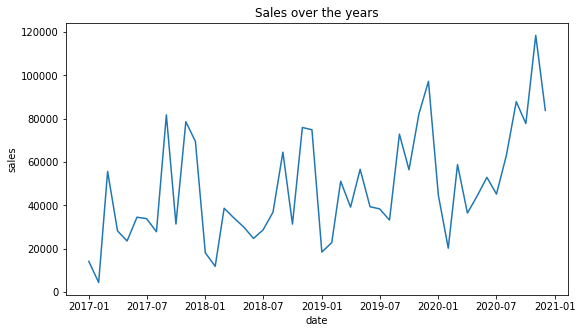

In [10]:
fig2 = plt.subplots( figsize = (9,5))
plot = sn.lineplot(x='date', y='sales', data=salesDF)
plot.set(title='Sales over the years')
plt.show()

In [11]:
I_df = salesDF.set_index('date') # set date as index
I_df['sales'] = I_df['sales'].astype(float)

###Decompose the previous years' sales to visualize the trend, seasonality, and residual

<Figure size 432x288 with 0 Axes>

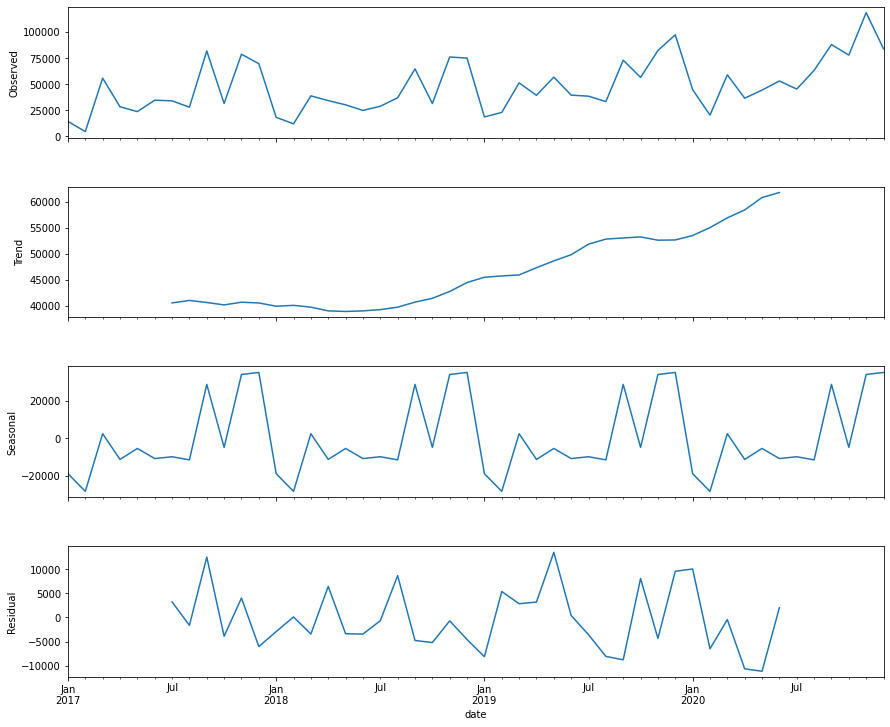

In [12]:
result = seasonal_decompose(I_df['sales'], model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)


###Forecast the next season (next 12 months) using triple exponential forecasting

In [13]:
dtt = pd.DataFrame(["01/01/2021","12/01/2021"])
dtt[0] = pd.to_datetime(dtt[0], format='%m/%d/%Y')
dtt = dtt.set_index(0)

# Apply Triple Exponential Smoothing
model1 = ExponentialSmoothing(I_df['sales'], trend='add', seasonal='add', seasonal_periods=12)
fit1 = model1.fit(use_boxcox=False, remove_bias=False)
predict1 = pd.Series(fit1.predict(start=dtt.index[0], end=dtt.index[1]), 
                       name='pred_sales').reset_index()

###Visualize the forecast

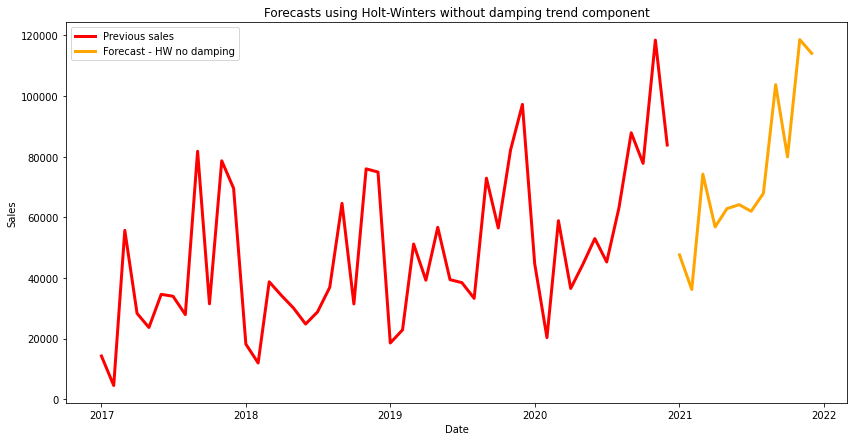

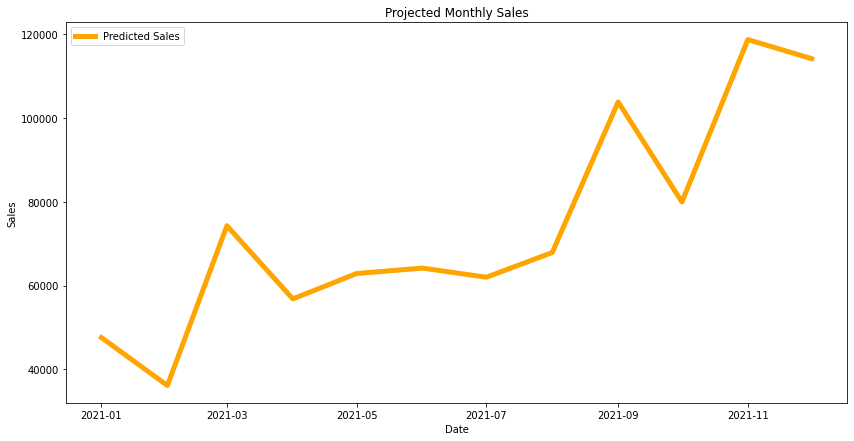

In [14]:
# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(salesDF['date'], salesDF['sales'], label='Previous sales', c="r",lw=3)
plt.plot(predict1["index"], predict1['pred_sales'], label='Forecast - HW no damping', c="orange", lw=3)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(predict1["index"], predict1['pred_sales'], label='Predicted Sales',c="orange", lw=5)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Projected Monthly Sales')
plt.show()

In [15]:
# rounded odd the forcasts to nearest 1000
predict1['pred_sales'] = round(predict1['pred_sales'],-3)
predict1 = predict1.rename(columns={"index":"date"})

###Using the forecast as the demand for next period, applying Wagner Whitin algorithim to schedule the production

In [16]:
# wagner whitin function
def wagner_whitin(fixcost, holdingcost,leadtime, demandDF):

	order = [] # creating optimum order list
	demand = np.array(demandDF["pred_sales"])
	n = len(demand)
	print("Period length: ", n)
	print("Forecasted demand: \n", demandDF)
	
	# Initializing cost matrix
	cost = [[0 for i in range(0,n)] for j in range(0, n)]

	# adding fixed cost and holding cost to the matrix
	for i in range(0, n):
		for j in range(i , n):
			cost[i][j] = cost[i][j] + fixcost
			for k in range(i+1, j+1):
				cost[i][j] = cost[i][j] + holdingcost*(k-i)*demand[k]


	#  initializing the optimal order cost within the period i, j
	F = [[0 for i in range(0,n)] for j in range(0, n)]
	order_mat = [[[j] for i in range(0,n)] for j in range(0, n)]

	for j in range(0, n):
		for i in range(0, j+1):
			F[j-i][j] = cost[j-i][j]
			for k in range(j-i, j):
				if (cost[j-i][k] + F[k+1][j] < F[j-i][j]):
					F[j-i][j] = cost[j-i][k] + F[k+1][j]
					order_mat[j-i][j] = [j-i, k+1]
	

	optimal = F[0][len(F)-1]

	order_periods = order_period(order_mat, len(demand))
	order = order_qty(order_periods, demand)

	print ("\n--------------------------------------------------Optimal Solution--------------------------------------------------")
	print ("Optimal Order Cost: $", optimal)
	print ("\nOrder quantity for each period: \n", order)
	order1 = pd.DataFrame({"date":demandDF["date"]-pd.DateOffset(months=leadtime),"production order":order})
	receipt = pd.DataFrame({"date":demandDF["date"],"Total inventory":order})
	scheduleDF = pd.merge(order1,demandDF,how="outer")
	scheduleDF = pd.merge(scheduleDF, receipt, how = "outer")
	scheduleDF = scheduleDF[['date', "pred_sales", "production order", "Total inventory"]]
	scheduleDF.replace(float("NaN"), 0 , inplace=True)
	return scheduleDF

In [17]:
#  define function to get the periods which needs to produce
def order_period(order_matrix, n):
	order_periods = []
	order_periods.append(0)
	next = order_matrix[0][n - 1][1]
	order_periods.append(next)
	while(len(order_matrix[next][n - 1]) == 2):
		order_periods.append(order_matrix[next][n - 1][1])
		next = order_matrix[next][n - 1][1]
	return order_periods

In [18]:
# define function to get the quantity of required for production
def order_qty(order_periods, demand):
	order = [0 for i in range(0, len(demand))]
	for i, num in enumerate(order_periods):
		order[num] = sum(demand[num:order_periods[i+1]]) if (i + 1 < len(order_periods)) else sum(demand[num:len(demand)])
	return order

###Wagner Whitin result

#####(assuming the fixed cost is 30000  and holding cost per unit is 0.5 with a lead time of 1 month)

In [19]:
scheduleDF = wagner_whitin (fixcost = 30000, holdingcost = 0.5, leadtime = 1, demandDF = predict1)

Period length:  12
Forecasted demand: 
          date  pred_sales
0  2021-01-01     48000.0
1  2021-02-01     36000.0
2  2021-03-01     74000.0
3  2021-04-01     57000.0
4  2021-05-01     63000.0
5  2021-06-01     64000.0
6  2021-07-01     62000.0
7  2021-08-01     68000.0
8  2021-09-01    104000.0
9  2021-10-01     80000.0
10 2021-11-01    119000.0
11 2021-12-01    114000.0

--------------------------------------------------Optimal Solution--------------------------------------------------
Optimal Order Cost: $ 346500.0

Order quantity for each period: 
 [84000.0, 0, 131000.0, 0, 63000.0, 64000.0, 62000.0, 68000.0, 104000.0, 80000.0, 119000.0, 114000.0]


###Schedule of demand, productrion order and inventory status

In [20]:
scheduleDF["available inventory"]=[0 for i in range(0,13)]
for i in range(1,13):
  scheduleDF["available inventory"].loc[i]= scheduleDF["available inventory"].loc[i-1]+scheduleDF["Total inventory"].loc[i] - scheduleDF["pred_sales"].loc[i]
scheduleDF

,date,pred_sales,production order,Total inventory,available inventory
0,2020-12-01,0.0,84000.0,0.0,0.0
1,2021-01-01,48000.0,0.0,84000.0,36000.0
2,2021-02-01,36000.0,131000.0,0.0,0.0
3,2021-03-01,74000.0,0.0,131000.0,57000.0
4,2021-04-01,57000.0,63000.0,0.0,0.0
5,2021-05-01,63000.0,64000.0,63000.0,0.0
6,2021-06-01,64000.0,62000.0,64000.0,0.0
7,2021-07-01,62000.0,68000.0,62000.0,0.0
8,2021-08-01,68000.0,104000.0,68000.0,0.0
9,2021-09-01,104000.0,80000.0,104000.0,0.0


###Visualize the demand, production release order and inventory on hand status

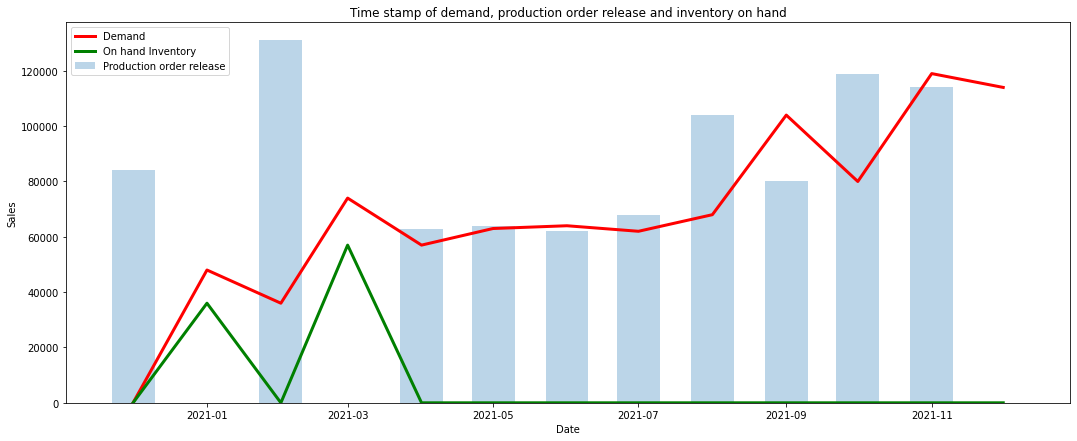

In [21]:
plt.figure(figsize=(18,7))
plt.plot(scheduleDF['date'], scheduleDF['pred_sales'], label='Demand', c="r",lw=3)
plt.plot(scheduleDF['date'], scheduleDF['available inventory'], label='On hand Inventory', c="g", lw=3)
plt.bar(scheduleDF['date'],scheduleDF['production order'],width = 18, alpha = 0.3, label='Production order release')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Time stamp of demand, production order release and inventory on hand')
plt.legend(loc='best')
plt.show()
